**Motivation**

The  motivation  behind developingmethods  for  face  recognition  at  long  distances  is  to  enable facial recognition technology in a broaderrange of applications. One of the main applications of facial  recognition  technology  is  in  security  and  surveillance  systems,  where  it  can  be  used  to identify  and  track  individuals  in real  time.  However,  traditional  facial  recognition  systems  are typically  limited  to  recognizing  faces  at  close  distances,  which  can  be  a  limitation  in specificenvironments such as airports, train stations, borders,and other public places where individuals are often far away from the camera.Overall, the development of methods for face recognition at long  distances  is  driven  by  the  need  to  improve facial  recognition  technology'saccuracy, efficiency, and scalability in a wide range of applications.

**Problem Statement and Overview**

Face recognition is thecomputer vision problem of finding the identityof human faces in digital images or video streams.

**Project Objectives**

Extend the original arcface loss function to improve its performance for the task of face recognition in long distances

**Dataset Description**

``DroneFace`` dataset is being used for this project. Below are some details about the dataset:

- 11 subjects including 7 males and 4 females.
- a total of 2,057 pictures including 620 raw images, 1,364 frontal face images, and 73 portrait images
- The raw images are taken in 3,680x2,760 resolution with ultra-wide field of view (170°) under daylights.
- The resolutions of the facial images are between 23x31 and 384x384.
- The raw images are taken from 1.5, 3, 4, and 5 meters high.
- The raw images are taken 2 to 17 meters away from the subjects with 0.5 meters interval.



# Data Preprocessing

In [1]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
import pickle
from data.data_pipe import get_loaders
from config.config import get_config


## Load the test embeddings 

In [2]:
with open("work_space/emb/test_embeddings_poseguided.pkl",'rb') as f:
    test_embeddings_poseguided = pickle.load(f)

with open("work_space/emb/test_embeddings_original.pkl",'rb') as f:
    test_embeddings_original = pickle.load(f)

# Model Evaluation

### ROC Curve

ROC (Receiver Operating Characteristic) is a curve that plots the True Positive Rate (TPR) against the False Positive Rate (FPR) for different classification thresholds. The area under the ROC curve (AUC) is often used as a measure of the overall performance of a binary classification model. 

A higher AUC indicates a better model performance in distinguishing positive and negative samples.

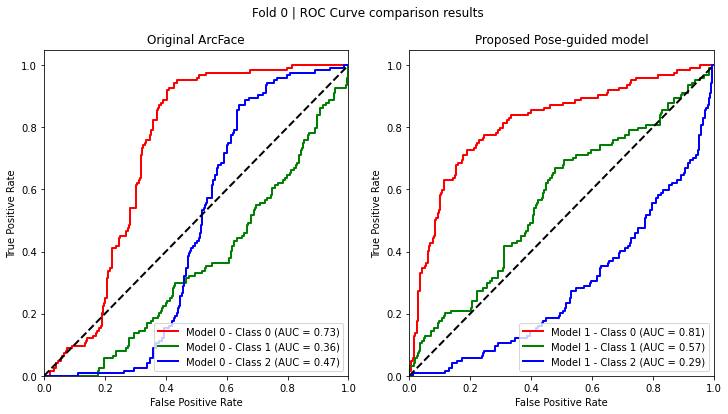

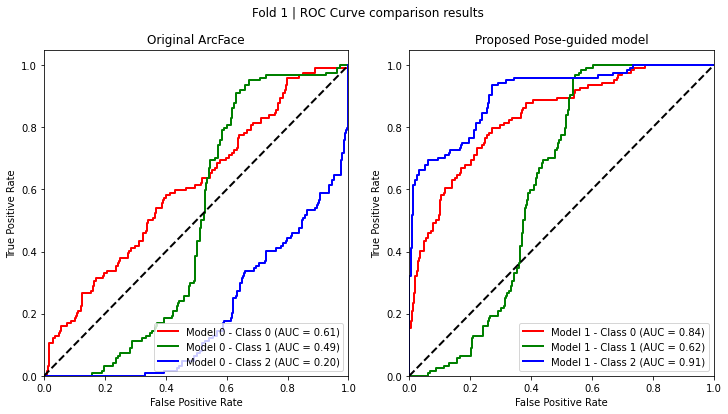

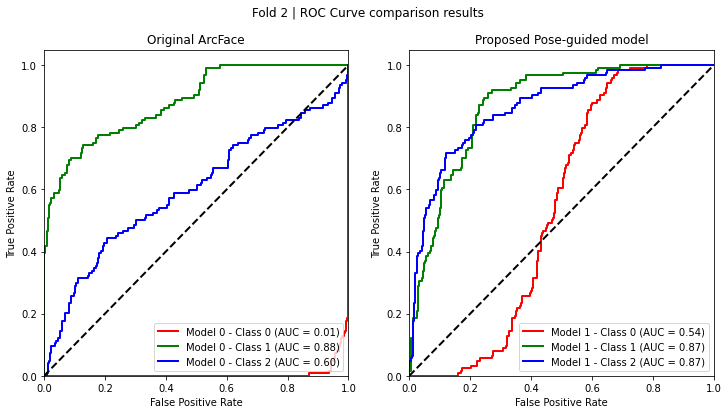

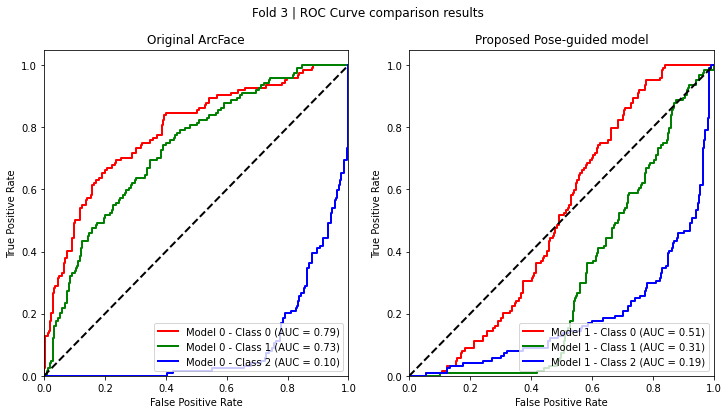

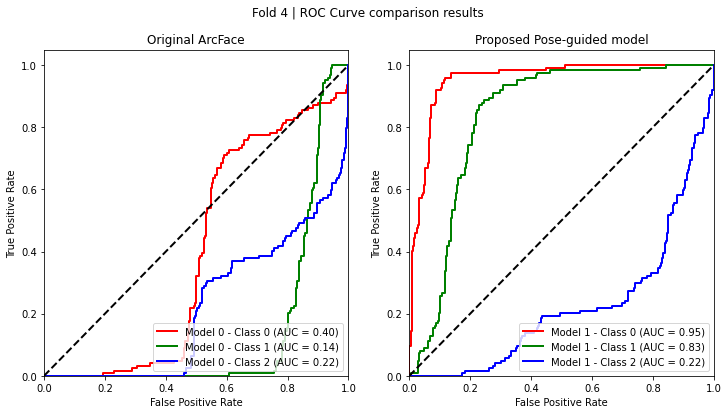

In [7]:
num_classes = 3
colors = ['red', 'green', 'blue']
lw = 2


for fold, (test_embs_original, test_embs_poseguided) in enumerate(zip(
    test_embeddings_original.values(), test_embeddings_poseguided.values()
)):
    test_labels = np.array([item['label'] for item in test_embs_original])

    test_embs_original_arr = np.array([item['embedding'].squeeze() for item in test_embs_original])
    test_embs_poseguided_arr = np.array([item['embedding'].squeeze() for item in test_embs_poseguided])

    fpr = {}
    tpr = {}
    roc_auc = {}
    for r, embeddings_set in enumerate([test_embs_original_arr, test_embs_poseguided_arr]):
        for i in range(num_classes):
            fpr[f'model_{r}_class_{i}'], tpr[f'model_{r}_class_{i}'], _ = roc_curve(test_labels == i, embeddings_set[:, i])
            roc_auc[f'model_{r}_class_{i}'] = auc(fpr[f'model_{r}_class_{i}'], tpr[f'model_{r}_class_{i}'])

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    models = ['Original ArcFace', 'Proposed Pose-guided model']
    for r, ax in enumerate(axs.flat):
        for i, color in enumerate(colors):
            label = f'Model {r} - Class {i} (AUC = {roc_auc[f"model_{r}_class_{i}"]:.2f})'
            ax.plot(fpr[f"model_{r}_class_{i}"], tpr[f"model_{r}_class_{i}"], color=color, lw=lw, label=label)

        ax.plot([0, 1], [0, 1], 'k--', lw=lw)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(models[r])
        ax.legend(loc="lower right")

    title = f'Fold {fold} | ROC Curve comparison results'
    fig.suptitle(title)
    plt.show()



### Average ROC Curve and AUC Results 

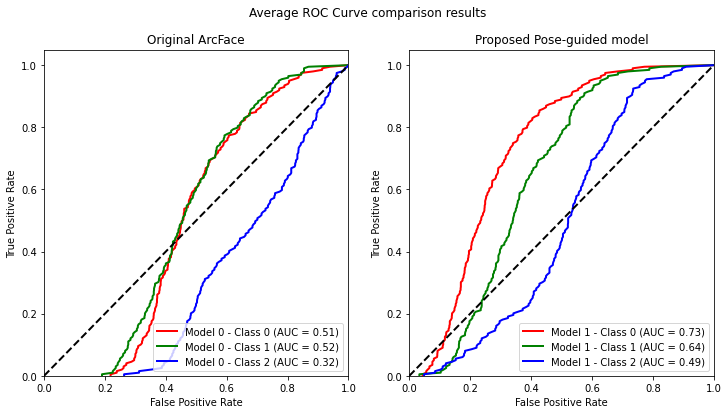

In [10]:
num_folds = 5
num_classes = 3
colors = ['red', 'green', 'blue']
lw = 2

num_points = 200

fpr_arr = np.zeros((2, num_classes, num_points))
tpr_arr = np.zeros((2, num_classes, num_points))
roc_auc_arr = np.zeros((2, num_classes))

for fold, (test_embs_original, test_embs_poseguided) in enumerate(zip(
    test_embeddings_original.values(), test_embeddings_poseguided.values()
)):
    test_labels = np.array([item['label'] for item in test_embs_original])
    test_embs_original_arr = np.array([item['embedding'].squeeze() for item in test_embs_original])
    test_embs_poseguided_arr = np.array([item['embedding'].squeeze() for item in test_embs_poseguided])

    for r, embeddings_set in enumerate([test_embs_original_arr, test_embs_poseguided_arr]):
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(num_classes):
            fpr[f'model_{r}_class_{i}'], tpr[f'model_{r}_class_{i}'], _ = roc_curve(test_labels == i, embeddings_set[:, i])
            roc_auc[f'model_{r}_class_{i}'] = auc(fpr[f'model_{r}_class_{i}'], tpr[f'model_{r}_class_{i}'])
            
        for i in range(num_classes):
            fpr_arr[r, i, :] += np.interp(np.linspace(0, 1, num_points), tpr[f"model_{r}_class_{i}"], fpr[f"model_{r}_class_{i}"])
            tpr_arr[r, i, :] += np.linspace(0, 1, num_points)
            roc_auc_arr[r, i] += roc_auc[f"model_{r}_class_{i}"]

for r in range(2):
    for i in range(num_classes):
        fpr_arr[r, i, :] /= num_folds
        tpr_arr[r, i, :] /= num_folds
        roc_auc_arr[r, i] /= num_folds

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
models = ['Original ArcFace', 'Proposed Pose-guided model']
for r, ax in enumerate(axs.flat):
    for i, color in enumerate(colors):
        label = f'Model {r} - Class {i} (AUC = {roc_auc_arr[r, i]:.2f})'
        ax.plot(fpr_arr[r, i, :], tpr_arr[r, i, :], color=color, lw=lw, label=label)

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(models[r])
    ax.legend(loc="lower right")

title = f'Average ROC Curve comparison results'
fig.suptitle(title)
plt.show()


## Discussion

### Cumulative Matching Characteristics (CMC) curve

The Cumulative Matching Characteristics (CMC) curve is a graph that shows the recognition performance of a biometric system as a function of the rank of the correct match. It is commonly used to evaluate the performance of face recognition systems.

The CMC curve is obtained by ranking the test images based on their similarity scores with the gallery images, from the highest to the lowest. Then, for each rank, we compute the proportion of test images that have been correctly identified as a match to a gallery image among the top K matches. The CMC curve plots the cumulative proportion of correct matches up to rank K, for different values of K.

For example, at rank 1, the CMC curve shows the proportion of test images that have been correctly identified as a match to their corresponding gallery image. At rank 5, the CMC curve shows the proportion of test images that have been correctly identified as a match to their corresponding gallery image among the top 5 matches. The CMC curve is useful for comparing the performance of different face recognition models, and for determining the rank at which the recognition performance starts to degrade.


### CMC Curve Comparison for each fold

In [ ]:

num_classes = 3 
num_folds = 5 

fig, axs = plt.subplots(nrows=num_folds, ncols=2, figsize=(10, 5*num_folds))
for i in range(num_folds):
    for j, embeddings in enumerate([test_embeddings_original[i], test_embeddings_poseguided[i]]):
        classes = sorted(list(set([emb['label'] for emb in embeddings])))
        num_embeddings = len(embeddings)

        # calculate class average embeddings
        class_embeddings = {c: [] for c in classes}
        for emb in embeddings:
            class_embeddings[emb['label']].append(emb['embedding'])
        class_average_embeddings = {}
        for c, emb_list in class_embeddings.items():
            if len(emb_list) > 0:
                class_average_embeddings[c] = np.mean(emb_list, axis=0)
            else:
                class_average_embeddings[c] = None

        # calculate pairwise cosine similarity between all embeddings and all class average embeddings
        similarities = np.zeros((num_embeddings, num_classes))
        for k, emb in enumerate(embeddings):
            for l, c in enumerate(classes):
                similarities[k, l] = cosine_similarity(emb['embedding'].reshape(1, -1),
                                                       class_average_embeddings[c].reshape(1, -1))

        # compute CMC curve
        cmc = np.zeros(num_classes)
        for k in range(num_embeddings):
            sorted_indices = np.argsort(similarities[k, :])[::-1]
            for l in range(num_classes):
                if classes[sorted_indices[l]] == embeddings[k]['label']:
                    cmc[l:] += 1
                    break

        cmc /= num_embeddings

        # plot CMC curve
        axs[i, j].plot(range(1, num_classes+1), cmc,)
        if j == 0: 
            title = f'Fold {i} | Original Model'
        else:
            title = f'Fold {i} | Pose-guided Model'
        axs[i, j].set_title(title)
        axs[i, j].set_xlabel("Rank")
        axs[i, j].set_ylabel("CMC Accuracy")
        axs[i, j].set_ylim([0, 1])

plt.tight_layout()
plt.show()


### Average results

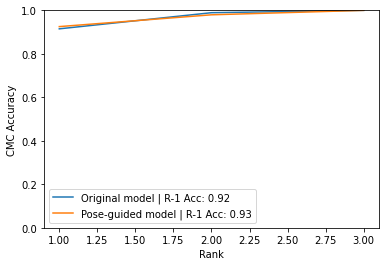

In [22]:
"""
Denote the original ArcFace model as Model 1
Denote the Pose-guided model as Model 2
"""

num_classes = 3  
num_folds = 5  

cmc_results = {}  
for model in ['Model 1', 'Model 2']:
    cmc_results[model] = np.zeros(num_classes)

    for i in range(num_folds):
        embeddings = test_embeddings_original[i] if model == 'Model 1' else test_embeddings_poseguided[i]
        classes = sorted(list(set([emb['label'] for emb in embeddings])))
        num_embeddings = len(embeddings)

        class_embeddings = {c: [] for c in classes}
        for emb in embeddings:
            class_embeddings[emb['label']].append(emb['embedding'])
        class_average_embeddings = {}
        for c, emb_list in class_embeddings.items():
            if len(emb_list) > 0:
                class_average_embeddings[c] = np.mean(emb_list, axis=0)
            else:
                class_average_embeddings[c] = None

        similarities = np.zeros((num_embeddings, num_classes))
        for k, emb in enumerate(embeddings):
            for l, c in enumerate(classes):
                similarities[k, l] = cosine_similarity(emb['embedding'].reshape(1, -1),
                                                       class_average_embeddings[c].reshape(1, -1))

        cmc = np.zeros(num_classes)
        for k in range(num_embeddings):
            sorted_indices = np.argsort(similarities[k, :])[::-1]
            for l in range(num_classes):
                if classes[sorted_indices[l]] == embeddings[k]['label']:
                    cmc[l:] += 1
                    break

        cmc /= num_embeddings
        cmc_results[model] += cmc

    cmc_results[model] /= num_folds

# plot average CMC curves
fig, ax = plt.subplots()
ax.plot(range(1, num_classes+1), cmc_results['Model 1'], label=f'Original model | R-1 Acc: {cmc_results["Model 1"][0]:.2f}')
ax.plot(range(1, num_classes+1), cmc_results['Model 2'], label=f'Pose-guided model | R-1 Acc: {cmc_results["Model 2"][0]:.2f}')
ax.set_xlabel("Rank")
ax.set_ylabel("CMC Accuracy")
ax.set_ylim([0, 1])
ax.legend()
plt.show()


In [21]:
cmc_results

{'Model 1': array([0.91505376, 0.98924731, 1.        ]),
 'Model 2': array([0.92526882, 0.97956989, 1.        ])}

### Discussion
